In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import torch as tc

#There is intentional division by zero in the UCB value function in the action-value estimation section, so we don't need to be
#warned about it
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

____
# ACTION-VALUE ESTIMATION

In [2]:
class nBandit:
    def __init__(self, index: int, n: int, total_steps: int, epsilon: float, plotting=True, step_mode = 'sample_average', choice_mode = 'ep_greedy'):
        '''
        Simulates the n-arm bandit decision system using action-value estimation. The inputs are:
         - index (int): numerical name of the bandit
         - n (int): number of arms
         - total_steps (int): length of simulation, or number of decisions made
         - epsilon (float): parameter for epsilon-greedy policy
         - plotting (bool) : determines whether or not to store the rewards from each decision for the purpose of plotting
         - step_mode (str) : the value function used by the agent, options are 'sample_average' and 'constant'
         - choice_mode (str) : policy used by agent, options are 'ep_greedy' (epsilon-greedy) and 'UCB' ()
        '''
        self.index = index
        self.arms = n
        self.time = 1
        self.ending = total_steps+1
        self.nongreed = epsilon
        self.rng = default_rng()
        self.values = self.rng.standard_normal((self.arms,))
        self.estimates = np.zeros((self.arms,))
        self.Nk = np.zeros((self.arms,))
        self.plotting = plotting
        if self.plotting:
            self.history = np.zeros((self.ending, self.arms))
        self.optimalCounter = 0
        self.mode = step_mode
        self.choice_mode = choice_mode
    
    def update_estimates(self, arm: int, reward: float, **kwargs):
        '''
        Updates the state value function using a recursive formula. The learning rate is either 1/k for the kth appearance of state
        or a constant.
        '''
        if self.mode == 'sample_average':
            self.estimates[arm] = self.estimates[arm] + (reward - self.estimates[arm])/self.Nk[arm]
        elif self.mode == 'constant':
            alpha = kwargs['step_size']
            self.estimates[arm] = self.estimates[arm] + alpha*(reward - self.estimates[arm])

    def act(self, **kwargs):
        '''
        Implements the policy chosen by the user. Though the real rewards are fixed when the class is initialized, the reward delivered to the
        agent is affected by a noise term to make learning the rewards harder to learn.
        '''
        if self.choice_mode == 'ep_greedy':
            if self.time <= self.ending:
                if np.allclose(self.estimates, self.estimates[0]):
                    action = self.rng.integers(0,self.arms)
                    reward = self.values[action] + self.rng.standard_normal()
                else:
                    r = self.rng.random()
                    if r >= self.nongreed:
                        action = np.argmax(self.estimates)
                        reward = self.values[action] + self.rng.standard_normal()
                        self.optimalCounter += 1
                    else:
                        gChoice = np.argmax(self.estimates)
                        action = self.rng.choice(np.delete(np.arange(0,self.arms,1,dtype=int),gChoice))
                        reward = self.values[action] + self.rng.standard_normal()
                self.Nk[action] += 1.
                self.update_estimates(action, reward)
        elif self.choice_mode == 'UCB':
            if self.time <= self.ending:
                if np.allclose(self.estimates, self.estimates[0]):
                    action = self.rng.integers(0,self.arms)
                    reward = self.values[action] + self.rng.standard_normal()
                else:
                    action = np.argmax(self.estimates + kwargs['exploration'] * np.sqrt(np.log(self.time)/self.Nk))
                    reward = self.values[action] + self.rng.standard_normal()

            self.Nk[action] += 1.
            self.update_estimates(action, reward, step_size = kwargs['step_size'])
        self.time += 1
        if self.plotting:
            self.history[self.time-1, action] = reward
        else:
            return

    def fullGame(self, **kwargs):
        '''
        kwargs: step_size, exploration
        '''
        if 'exploration' in kwargs.keys():
            for _ in range(self.ending-1):
                self.act(step_size = kwargs['step_size'], exploration = kwargs['exploration'])
        else:
            for _ in range(self.ending-1):
                self.act()

In [3]:
def banditTestbed(num_bandits: int, num_arms: int, num_steps: int, epsilon: list[float], step_mode: str, choice_mode: str, **kwargs):
    
    ensemble = []
    for i in range(num_bandits):
        ensemble.append(nBandit(index=i, n=num_arms, total_steps=num_steps, epsilon=epsilon, step_mode=step_mode, choice_mode=choice_mode))
        
    if 'exploration' in kwargs.keys():
        for bandit in ensemble:
            bandit.fullGame(step_size = kwargs['step_size'], exploration = kwargs['exploration'])
    else:
        for bandit in ensemble:
            bandit.fullGame()
    rewardHistory = np.sum(np.stack(np.array([bandit.history for bandit in ensemble])), axis=-1)
    
    avgReward = np.average(rewardHistory, axis=0)
    
    return avgReward

In [4]:
def rewardPlots1(num_bandits: int, num_arms: int, num_steps: int, epsilon: list[float], step_mode: str, choice_mode: str, **kwargs):
    rewardContainer = []
    
    for ep in epsilon:
        if 'exploration' in kwargs.keys():
            reward = banditTestbed(num_bandits, num_arms, num_steps, ep, step_mode=step_mode, choice_mode=choice_mode,
                                   step_size = kwargs['step_size'], exploration = kwargs['exploration'])
            rewardContainer.append(reward)
        else:
            reward = banditTestbed(num_bandits, num_arms, num_steps, ep, step_mode=step_mode, choice_mode=choice_mode)
            rewardContainer.append(reward)
        
    for i in range(len(epsilon)):
        plt.plot(rewardContainer[i][:-1], label='epsilon = ' + f'{epsilon[i]}')
        plt.legend()
        plt.xlabel('Steps')
        plt.ylabel('Average Reward')
        plt.show

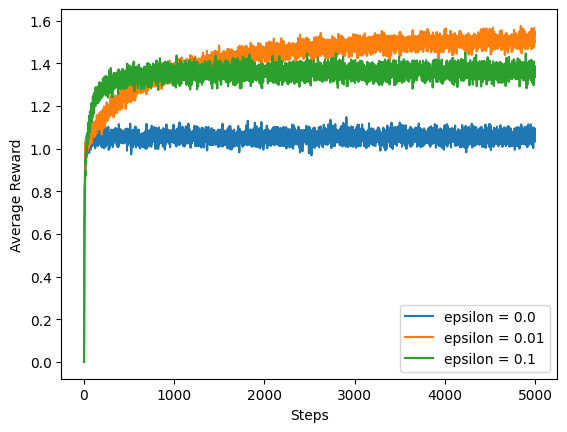

In [5]:
rewardPlots1(2000, 10, 5000, [0., 0.01, 0.1], step_mode='sample_average', choice_mode = 'ep_greedy')

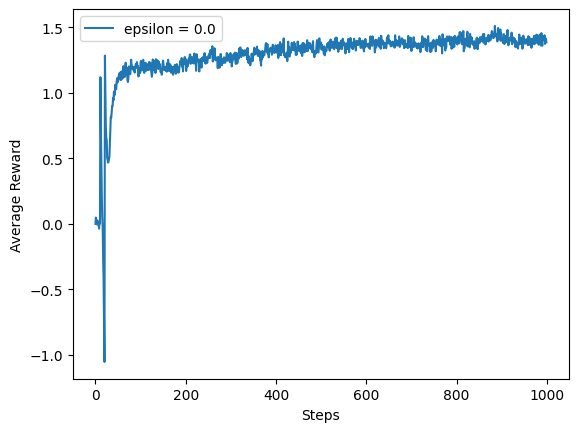

In [6]:
rewardPlots1(1000, 10, 1000, [0.], step_mode='constant', choice_mode='UCB', step_size = 0.1, exploration = 2.0)

____
# NUMERICAL PREFERENCE (BOLTZMANN)

In [7]:
class boltzBandit:
    def __init__(self, n_arms: int, total_steps: int, learning_rate: float, backend = 'numpy'):
        '''
        Simulates the n-arm bandit using numerical preference, where each state is assigned a probability of being chosen based on
        some preference function. The joint probability distribution is the Boltzmann or softmax distribution, making the
        preference function like the states energy. The inputs are:
         - n_arms: number of arms
         - total_steps: length of simulation or number of decisions
         - learning_rate: parameter in recursive update used to learn the preference function
         - backend: framework for running the simulation, options are 'numpy' and 'torch'
        '''
        self.backend = backend
        
        self.arms = n_arms
        self.time = 1
        self.ending = total_steps+1
        self.rng = default_rng()
        self.values = self.rng.standard_normal((self.arms,))
        self.baseline = 0.
        if self.backend == 'numpy':
            self.preference = np.zeros((n_arms,))
        elif self.backend == 'torch':
            self.preference = tc.zeros((n_arms))
            self.probability = tc.nn.Softmax(0)
        self.rate = learning_rate
        self.history = np.zeros((self.ending, self.arms))
        
    def Boltzmann(self, arm: int):
        '''
        Implements the Boltzmann or softmax distribution. Input is the number of arms.
        '''
        if self.backend == 'numpy':
            pFun = np.sum(np.exp(self.preference))
            return np.exp(self.preference[arm])/pFun
        elif self.backend == 'torch':
            return self.probability(self.preference)[arm]
    
    def updateBaseline(self, outcome: float):
        '''
        Updates the average total reward.
        '''
        self.baseline = ((self.time-1)/self.time)*self.baseline + outcome/self.time
    
    def updatePreference(self, arm: int, outcome: float):
        '''
        Implements a stoachastic gradient ascent recursion relation to update the preference function estimate.
        '''
        for i in range(self.arms):
            if i == arm:
                self.preference[arm] = self.preference[arm] + self.rate*(outcome-self.baseline)*(1-self.Boltzmann(arm))
            else:
                self.preference[i] = self.preference[i] - self.rate*(outcome-self.baseline)*self.Boltzmann(i)
                
    def act(self):
        '''
        Implements the policy where the maximally likely action is chosen.
        '''
        if np.allclose(self.preference, self.preference[0]):
            action = self.rng.integers(0,self.arms)
            reward = self.values[action] + self.rng.standard_normal()
        else:
            if self.backend == 'numpy':
                action = np.argmax(self.preference)
            elif self.backend == 'torch':
                action = tc.argmax(self.preference)
                action = action.numpy()
            reward = self.values[action] + self.rng.standard_normal()

        self.updateBaseline(reward)
        self.time += 1
        self.updatePreference(action, reward)
        self.history[self.time-1, action] = reward
        
    def fullGame(self):
        for _ in range(self.ending-1):
            self.act()

In [8]:
def boltzmannBanditTestbed(num_bandits: int, num_arms: int, num_steps: int, learning_rate: float, backend = 'numpy', **kwargs):
    
    ensemble = []
    for i in range(num_bandits):
        ensemble.append(boltzBandit(num_arms, total_steps=num_steps, learning_rate=learning_rate, backend=backend))
        
    for bandit in ensemble:
        bandit.fullGame()
    
    rewardHistory = np.sum(np.stack(np.array([bandit.history for bandit in ensemble])), axis=-1)
    
    avgReward = np.average(rewardHistory, axis=0)

    return avgReward

In [9]:
def rewardPlots2(num_bandits: int, num_arms: int, num_steps: int, learning_rate: float, backend = 'numpy', **kwargs):
    rewardContainer = []
    
    for sz in learning_rate:
        reward = boltzmannBanditTestbed(num_bandits, num_arms, num_steps, sz, backend)
        rewardContainer.append(reward)
        
    for i in range(len(learning_rate)):
        plt.plot(rewardContainer[i][:-1], label='l_rate = ' + f'{learning_rate[i]}')
        plt.legend()
        plt.xlabel('Steps')
        plt.ylabel('Average Reward')
        plt.show

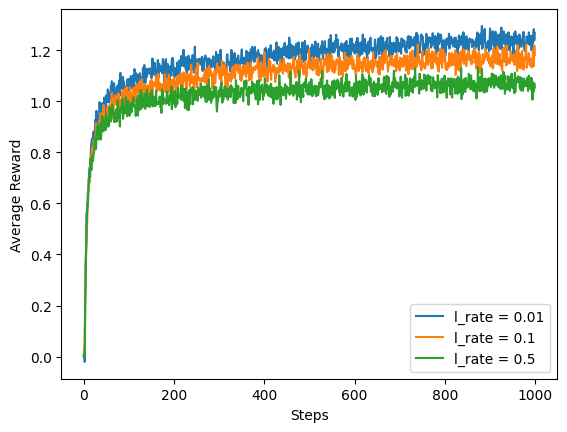

In [10]:
rewardPlots2(2000, 10, 1000, [0.01, 0.1, 0.5], backend='torch')

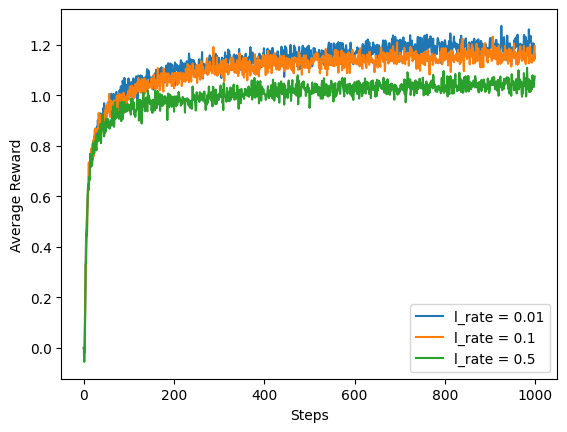

In [11]:
rewardPlots2(2000, 10, 1000, [0.01, 0.1, 0.5], backend='numpy')